In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imripy import constants as c, merger_system as ms, halo, inspiral, waveform, detector, plot_utils as pu, kepler
import plotting

This notebook shows an example of the GW signal that an inspiral can emit. It takes two different inspiral, one at lower eccentricity, and one at higher and lets it inspiral with GW emission as the only dissipative force.
The result shows the different braking indices in the high and low eccentricity cases, $n_b=4/3$ and $n_b=11/3$, respectively, and at the end shows a Q-plot of the first five harmonics.

In [2]:
# Example System
m1 = 1e5 *c.solar_mass_to_pc
m2 = 10. *c.solar_mass_to_pc
D = 5e8

hs = ms.HostSystem(m1, D_l=D, )

In [3]:
a0 = 50.*hs.r_isco
e0 = 0.99
ko = kepler.KeplerOrbit(hs, m2, a0, e0)

opt = inspiral.Classic.EvolutionOptions(dissipativeForces=[inspiral.forces.GWLoss()], accuracy=1e-13)
ev_high_e = inspiral.Classic.Evolve(hs, ko, opt=opt)

Evolving from  50.0  to  1.0 r_isco  with initial eccentricity 0.99  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 1.000e+00r_isco. Evolution took 0.1525s real time


In [4]:
a0 = 20.*hs.r_isco
e0 = 0.3
ko2 = kepler.KeplerOrbit(hs, m2, a0, e0)

ev_low_e = inspiral.Classic.Evolve(hs, ko2, opt=opt)

Evolving from  20.0  to  1.0 r_isco  with initial eccentricity 0.3  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0783s real time


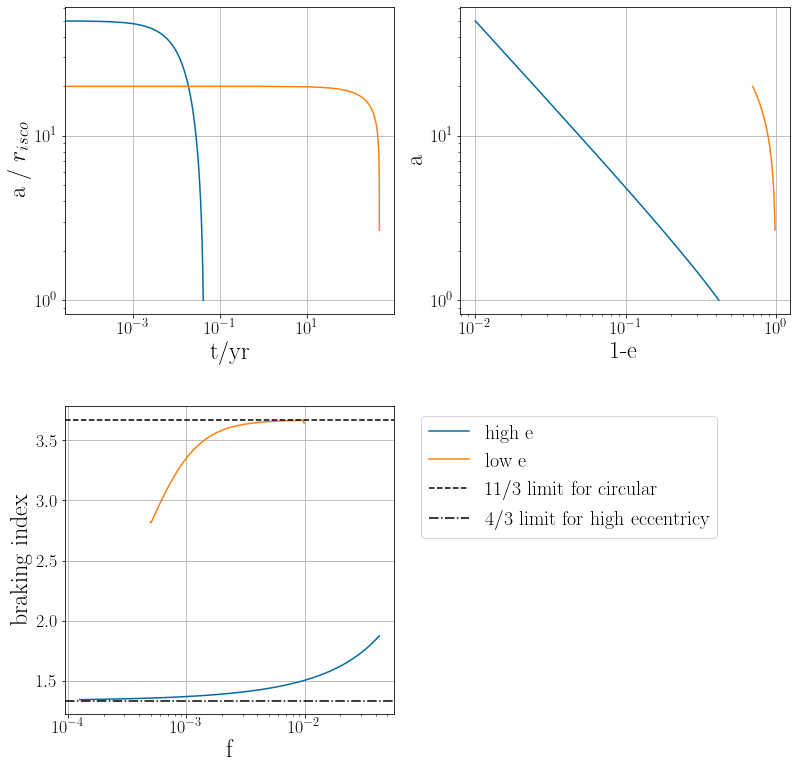

In [5]:
fig =plt.figure(figsize=(13,13) )
ax_a = fig.add_subplot(2,2,1)
ax_ae = fig.add_subplot(2,2,2)
ax_n = fig.add_subplot(2,2,3)

pu.plotEvolution(hs, ev_high_e, ax_a=ax_a, ax_1mea=ax_ae, ax_n = ax_n, label='high e')
pu.plotEvolution(hs, ev_low_e, ax_a=ax_a, ax_1mea=ax_ae, ax_n = ax_n, label='low e')

ax_n.axhline(11./3., linestyle='--', color='black', label="$11/3$ limit for circular")
ax_n.axhline(4./3., linestyle='-.', color='black', label="$4/3$ limit for high eccentricy")

ax_a.grid(); ax_a.set_xscale('log'); ax_a.set_ylabel('a / $r_{isco}$'); ax_a.set_xlabel("t/yr")
ax_ae.grid(); ax_ae.set_xscale('log'); ax_ae.set_ylabel('a'); ax_ae.set_xlabel('1-e')
ax_n.grid(); ax_n.set_xscale('log'); ax_n.set_ylabel("braking index"); ax_n.set_xlabel("f")
ax_n.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.subplots_adjust(hspace=0.3)

In [6]:
n_comp = 6
n_disp = 5

wfs_high_e = [waveform.h_n(n, hs, ev_high_e, acc=1e-13) for n in range(1, n_comp+1)]
wfs_low_e = [waveform.h_n(n, hs, ev_low_e, acc=1e-13) for n in range(1, n_comp+1)]

In [7]:
f_gw = np.geomspace(np.min(wfs_high_e[0][0]), np.max(wfs_high_e[n_disp][0]), 5000)

In [8]:
def Q_plot(t_plot, f_plot, ev, wfs, ax_h_p=None, ax_h_c=None):
    h_plus_plot = np.zeros(shape=np.shape(t_plot))
    h_cross_plot = np.zeros(shape=np.shape(t_plot))
    for i in range(len(t_plot[0])):
        for wf in wfs:
            f = np.interp(t_plot[0, i], ev.t, wf[0], left=0., right=0.)
            index_f = (np.abs(f_plot[:, i] - f)).argmin()
            h_plus_plot[index_f, i] = np.abs(np.interp(f_plot[index_f, i], wf[0], wf[1]))
            h_cross_plot[index_f, i] = np.abs(np.interp(f_plot[index_f, i], wf[0], wf[2]))
        
    h_plus_plot = h_plus_plot/np.max(h_plus_plot)
    
    if ax_h_p is not None:
        ax_h_p.contourf( t_plot/c.year_to_pc, f_plot/c.hz_to_invpc, h_plus_plot, cmap='YlOrRd')
    if ax_h_c is not None:
        ax_h_c.contourf( t_plot/c.year_to_pc, f_plot/c.hz_to_invpc, h_cross_plot, cmap=plt.get_cmap("YlOrRd"))
    

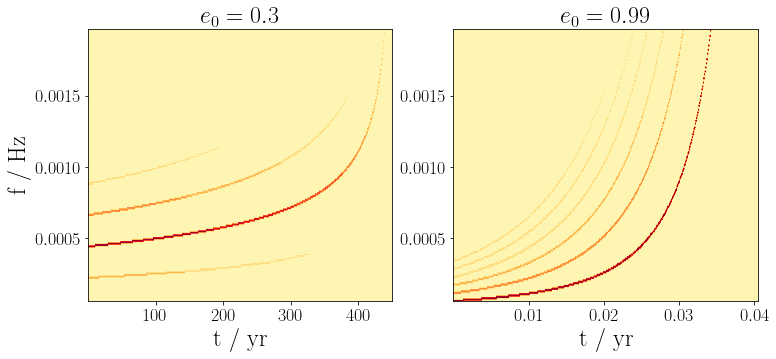

In [9]:
fig, (ax_low_e, ax_high_e) = plt.subplots(1,2 , figsize=(12, 5))

t_plot = np.linspace(np.min(ev_high_e.t) if ev_high_e.t[0] > 0. else ev_high_e.t[1]*1e-1, np.max(ev_high_e.t), 500)
f_plot = np.linspace(np.min(f_gw), np.max(f_gw)/60., 200)
t_plot, f_plot = np.meshgrid(t_plot, f_plot)
Q_plot(t_plot, f_plot, ev_high_e, wfs_high_e, ax_h_p=ax_high_e)

t_plot = np.linspace(np.min(ev_low_e.t) if ev_low_e.t[0] > 0. else ev_low_e.t[1]*1e-1, np.max(ev_low_e.t), 500)
f_plot = np.linspace(np.min(f_gw), np.max(f_gw)/60., 200)
t_plot, f_plot = np.meshgrid(t_plot, f_plot)
Q_plot(t_plot, f_plot, ev_low_e, wfs_low_e, ax_h_p=ax_low_e)


for ax in (ax_high_e, ax_low_e):
    ax.set_xlabel("t / yr"); 
ax_low_e.set_ylabel("f / Hz")
ax_low_e.set_title("$e_0 = 0.3$")
ax_high_e.set_title("$e_0 = 0.99$")
fig.savefig("plots/Qplot.pdf", bbox_inches='tight')